In [15]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter

## Individual class

In [16]:
#Population Class
class Individual:
    def __init__(self, 
                 VarMin = -5 , VarMax = 5 , nVar = 3 , 
                 Rank=0 , 
                 DominationSet=[] , 
                 DominatedCount=0, 
                 CrowdingDistance=[]):
        
        self.Position = np.random.randint(VarMin , VarMax , nVar)
        self.Cost = MOP4(self.Position)
        self.Rank = Rank
        self.DominationSet = DominationSet
        self.DominatedCount = DominatedCount
        self.CrowdingDistance = CrowdingDistance

# Functions

In [17]:
#Objective fnction
def MOP2(x):
    n = np.size(x)
    z1=1-np.exp(-np.sum((x-1/np.sqrt(n))**2))
    z2=1-np.exp(-np.sum((x+1/np.sqrt(n))**2))
    return np.array([z1 , z2])
    

In [18]:
def MOP4(x):

    n = np.size(x)
    a=0.8
    b=3
    
#    z1=sum(-10*exp(-0.2*sqrt(x(1:end-1).^2+x(2:end).^2)));
    z1 = np.sum([-10*np.exp(-0.2*np.sqrt((x[i]**2)+(x[i+1]**2))) for i in range(n-1)])
    
    z2 = np.sum(np.abs(x)**a+5*(np.sin(x))**b)
    
    return np.array([z1 , z2])

In [19]:
# Dominate check function

def Dominates(x , y):
    if isinstance(x , Individual):
        x=x.Cost
    if isinstance(y , Individual):
        y=y.Cost
    
    return np.all(x<=y) & np.any(x<y)

In [20]:
#Non Dominated Sorting
def NonDominatedSorting(pop):
    #init
    nPop = np.size(pop)
    F={}
    F[1]=[]
    for i in range(nPop):
        
        #initialization
        pop[i].DominationSet=[]
        pop[i].DominatedCount=0
    
    # Domination check for every individal
    for i in range(nPop):
        for j in range(i+1 , nPop):
            p=pop[i]
            q=pop[j]
            if Dominates(p , q):
                p.DominationSet.append(j)
                q.DominatedCount=q.DominatedCount+1
                
            if Dominates(q ,p ):
                q.DominationSet.append(i)
                p.DominatedCount=p.DominatedCount+1
            
            pop[i] = p
            pop[j] = q
            
        if pop[i].DominatedCount==0:
            F[1].append(i)
            pop[i].Rank=1
                
    k=1
    
    # Updating the fronts
    while True: 
        Q=[]
        
        for i in F[k]:
            p=pop[i]
            
            for j in p.DominationSet:
                
                q=pop[j]
                q.DominatedCount=q.DominatedCount-1
                
                if q.DominatedCount==0:
                    Q.append(j)
                    q.Rank=k+1
                
                pop[j]=q
        
        if not Q:
            break
        
        F[k+1]=Q
        k=k+1
    return pop , F

In [21]:
# Crowding distance calculation
def CalcCrowdingDistance (pop , F):

    nF=len(F)
    #Looping through each Front
    for k in range(1 , nF+1):
        
        Costs = [pop[x].Cost.tolist() for x in F[k]]
        
        nObj=len(Costs[0])
        
        n = len(F[k])
        
        d=np.zeros((n,nObj))
        
        for j in range(nObj):
            
            # Sorted indices
            so = [i[0] for i in sorted(enumerate(Costs), key=lambda x:x[1][j])]
            # Sorted values
            cj = [ x[j] for x in sorted(Costs, key=itemgetter(j), reverse=False)]
            
            # Setting a high number for the first value of the front 
            d[so[0],j] = np.Inf
            
            
            if n>2:
                for i in range(1 , n-1):
                    
                    if abs(cj[0]-cj[-1]) !=0:
                        d[so[i],j]= abs(cj[i+1] - cj[i-1]) / abs(cj[0]-cj[-1])
                    else:
                        d[so[i],j] = 0
                        
            # Setting a high number for the Last value of the front 
            d[so[-1],j] = np.Inf
            
        for i in range(n):
            pop[F[k][i]].CrowdingDistance = sum(d[i,:])
    return pop
        

In [22]:
def SortPopulation(pop):

    # Sort Based on Crowding Distance
    pop = sorted(pop, key=lambda x: x.CrowdingDistance, reverse=True)
    
    # Sort Based on Rank
    pop = sorted(pop, key=lambda x: x.Rank, reverse=False)
    
    
    
    # # Update Fronts
    Ranks=[pop[i].Rank for i in range(nPop)]
    MaxRank=max(Ranks)
    F={}
    
    for r in range(1 , MaxRank+1):
        F[r]=[i for i, e in enumerate(Ranks) if e == r]
        
    return pop , F
    

In [23]:
def Crossover(x1,x2):

    alpha=np.random.rand(len(x1))
    
    y1 = alpha * x1 + (1-alpha)*x2
    y2 = alpha * x2 + (1-alpha)*x1
    return y1 , y2

In [24]:
# Mutation Method
def Mutate(x,mu,sigma):
    
    nVar = np.size(x)
    nMu = math.ceil(mu*nVar)
    
    j = random.sample(range(nVar),nMu)
    
    y=x
    y[j]= x[j] + sigma * np.random.randn(len(j))
    
    return y

# Initialization

In [25]:
nVar = 3           # Number of Decision Variables
VarMin=-5          # Lower Bound of Variables
VarMax= 5          # Upper Bound of Variables

# nmber of objective functions
nobj = np.size(MOP4(np.random.randint(VarMin , VarMax , nVar)))

In [26]:
## NSGA-II Parameters

MaxIt=100;      # Maximum Number of Iterations

nPop=50;        # Population Size

pCrossover=0.7;                         # Crossover Percentage
nCrossover=2*round(pCrossover*nPop/2);  # Number of Parnets (Offsprings)

pMutation=0.4;                          # Mutation Percentage
nMutation=round(pMutation*nPop);        # Number of Mutants

mu=0.02;                    # Mutation Rate

sigma=0.1*(VarMax-VarMin);  # Mutation Step Size

In [27]:
#Creating our Population
pop = np.empty(nPop , dtype=Individual)
for i in range(nPop):
    pop[i] = Individual(VarMin = VarMin , VarMax = VarMax , nVar = nVar )

In [28]:
# Sorting the population
pop , F = NonDominatedSorting(pop)
pop = CalcCrowdingDistance(pop,F)
pop , F = SortPopulation(pop)

# Main NSGA-ii Loop

Iteration 0: Number of F1 Members = 5
Iteration 1: Number of F1 Members = 9
Iteration 2: Number of F1 Members = 11
Iteration 3: Number of F1 Members = 12
Iteration 4: Number of F1 Members = 14
Iteration 5: Number of F1 Members = 17
Iteration 6: Number of F1 Members = 23
Iteration 7: Number of F1 Members = 28
Iteration 8: Number of F1 Members = 37
Iteration 9: Number of F1 Members = 36
Iteration 10: Number of F1 Members = 40
Iteration 11: Number of F1 Members = 43
Iteration 12: Number of F1 Members = 47
Iteration 13: Number of F1 Members = 50
Iteration 14: Number of F1 Members = 50
Iteration 15: Number of F1 Members = 50
Iteration 16: Number of F1 Members = 50
Iteration 17: Number of F1 Members = 50
Iteration 18: Number of F1 Members = 50
Iteration 19: Number of F1 Members = 50
Iteration 20: Number of F1 Members = 50
Iteration 21: Number of F1 Members = 50
Iteration 22: Number of F1 Members = 50
Iteration 23: Number of F1 Members = 50
Iteration 24: Number of F1 Members = 50
Iteration 25

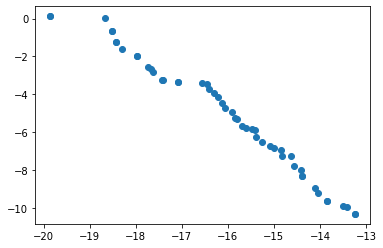

In [29]:
for it in range(MaxIt):
    
    #Cross Over 
    popc = np.empty((int(nCrossover/2) , 2) , dtype=Individual)
    
    for k in range(int(nCrossover/2)):
        popc[k,0]=Individual()
        popc[k,1]=Individual()
        
        i1 = np.random.randint(0 , nPop)
        p1=pop[i1]
        
        i2 = np.random.randint(0 , nPop)
        p2=pop[i2]
        
        popc[k,0].Position , popc[k,1].Position = Crossover(p1.Position,p2.Position)
        
        popc[k,0].Cost = MOP4(popc[k,0].Position )
        popc[k,1].Cost = MOP4(popc[k,1].Position )
        
    popc = np.reshape(popc , nCrossover)
#-------------------------------------------------------------------------------------->>>>>>>>
    #Mutation
    popm = np.empty(nMutation , dtype=Individual)

    for k in range(nMutation):
        popm[k] = Individual()
        i = np.random.randint(0 , nPop)
        p=pop[i]
        popm[k].Position=Mutate(p.Position,mu,sigma)
        popm[k].Cost = MOP4(popc[k].Position )
#-------------------------------------------------------------------------------------->>>>>>>>       
    # Merging the population with Crossovers and mutated population
    pop = pop+popc.tolist()+popm.tolist()
    
    #Sorting the new population
    pop , F = NonDominatedSorting(pop)
    pop = CalcCrowdingDistance(pop,F)
    pop , F = SortPopulation(pop)

    #Truncating the population
    pop = pop[0:nPop]

    #Sorting the truncated population
    pop , F = NonDominatedSorting(pop)
    pop = CalcCrowdingDistance(pop,F)
    pop , F = SortPopulation(pop)

#-------------------------------------------------------------------------------------->>>>>>>>       
    # Storing the pareto front
    F1= [pop[i] for i in F[1]]
    print('Iteration ' + str(it)+': Number of F1 Members = ' + str(len(F1)))
 #-------------------------------------------------------------------------------------->>>>>>>>       
#plotting the Final results
x = [[F1[j].Cost[0] for j in range(len(F1))]]
y = [[F1[j].Cost[1] for j in range(len(F1))]]
fig, ax = plt.subplots()
ax.scatter(x, y, marker='o')
plt.show()
    

Author:
Mohsen Ghasemi
email: shahin1009@gmail.com